In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score

# Checking if CUDA is available
flag_cuda = torch.cuda.is_available()

if not flag_cuda:
    print('Using CPU')
else:
    print('Using GPU')


from torchvision import datasets
import torchvision.transforms as transforms
import torchvision
from torch.utils.data import  DataLoader
from torch.utils.data.sampler import SubsetRandomSampler

import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

Using CPU


In [ ]:
torch.manual_seed(0)

# Convert data to a normalized torch.FloatTensor
transform = transforms.Compose([
    transforms.Resize((150,150)),
    # transforms.CenterCrop(10)
    # transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])


#  do not rotate

In [ ]:
train_path = '/content/drive/MyDrive/Colab Notebooks/projF/balanced_train_data'
validation_path = '/content/drive/MyDrive/Colab Notebooks/projF/balanced_validation_data'

batch_size  = 100
n_epochs = 80

def make_weights_for_balanced_classes(images, nclasses):                        
    count = [0] * nclasses                                                      
    for item in images:                                                         
        count[item[1]] += 1                                                     
    weight_per_class = [0.] * nclasses                                      
    N = float(sum(count))                                                   
    for i in range(nclasses):                                                   
        weight_per_class[i] = N/float(count[i])                                 
    weight = [0] * len(images)                                              
    for idx, val in enumerate(images):                                          
        weight[idx] = weight_per_class[val[1]]                                  
    return weight    

dataset_train = datasets.ImageFolder(train_path)                                                                         
                                                                                
# For unbalanced dataset we create a weighted sampler                       
weights = make_weights_for_balanced_classes(dataset_train.imgs, len(dataset_train.classes))                                                                
weights = torch.DoubleTensor(weights)                                       
sampler = torch.utils.data.sampler.WeightedRandomSampler(weights, len(weights)) 

train_loader = DataLoader(
    torchvision.datasets.ImageFolder(train_path, transform=transform), batch_size=batch_size, sampler = sampler)

validation_loader = DataLoader(
    torchvision.datasets.ImageFolder(validation_path, transform=transform), batch_size=batch_size)

test_loader = DataLoader(
    torchvision.datasets.ImageFolder(validation_path, transform=transform), shuffle = False)

train_indx , valid_indx = 601-181, 181

# specify the image classes
classes = ['cataract','glaucoma', 'normal', 'retina_disease']

In [ ]:
# Defining the CNN architecture
class Net(nn.Module):
  def __init__(self):
    super(Net, self).__init__()
    self.conv1 = nn.Conv2d(3,5,3,1,1)
    self.batch1 = nn.BatchNorm2d(5)
    self.pool = nn.MaxPool2d(2, 2)
    self.conv2 = nn.Conv2d(5, 4, 3)
    self.batch2 = nn.BatchNorm2d(4)
    self.fc1 = nn.Linear(4*36*36,  30)
    self.batch3 = nn.BatchNorm1d(30)
    self.fc2 = nn.Linear(30, 16)
    self.batch4 = nn.BatchNorm1d(16)
    self.fc3 = nn.Linear(16, 4)
    # self.softmax = nn.Softmax(dim=1)
  def forward(self, x):
    x = self.pool(F.relu(self.batch1(self.conv1(x))))
    x = self.pool(F.relu(self.batch2(self.conv2(x))))
    x = x.view(-1, 4*36*36) # At this point the feature map is 5 x 5 x 16
    x = F.relu(self.batch3(self.fc1(x)))
    x = F.relu(self.batch4(self.fc2(x)))
    x = self.fc3(x)
    return x

# Create a complete CNN
model = Net()
print(model)

# Move tensors to GPU if CUDA is available
if flag_cuda:
  model.cuda()

# Specifying the loss function
criterion = nn.CrossEntropyLoss()

# Specify optimizer
optimizer = optim.Adam(model.parameters())

Net(
  (conv1): Conv2d(3, 5, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (batch1): BatchNorm2d(5, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(5, 4, kernel_size=(3, 3), stride=(1, 1))
  (batch2): BatchNorm2d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc1): Linear(in_features=5184, out_features=30, bias=True)
  (batch3): BatchNorm1d(30, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc2): Linear(in_features=30, out_features=16, bias=True)
  (batch4): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc3): Linear(in_features=16, out_features=4, bias=True)
)


Epoch: 1 	Training Loss: 1.377130 	Validation Loss: 1.408544
Validation loss decreased (inf --> 1.408544).  Saving model ...
Epoch: 2 	Training Loss: 1.212142 	Validation Loss: 1.512124
Epoch: 3 	Training Loss: 1.184062 	Validation Loss: 1.526223
Epoch: 4 	Training Loss: 1.128368 	Validation Loss: 1.462655
Epoch: 5 	Training Loss: 1.109723 	Validation Loss: 1.379700
Validation loss decreased (1.408544 --> 1.379700).  Saving model ...
Epoch: 6 	Training Loss: 1.054834 	Validation Loss: 1.394178
Epoch: 7 	Training Loss: 1.067258 	Validation Loss: 1.413912
Epoch: 8 	Training Loss: 0.995048 	Validation Loss: 1.241877
Validation loss decreased (1.379700 --> 1.241877).  Saving model ...
Epoch: 9 	Training Loss: 0.989821 	Validation Loss: 1.333281
Epoch: 10 	Training Loss: 0.939189 	Validation Loss: 1.247516
Epoch: 11 	Training Loss: 0.947932 	Validation Loss: 1.259503
Epoch: 12 	Training Loss: 0.896614 	Validation Loss: 1.543061
Epoch: 13 	Training Loss: 0.876027 	Validation Loss: 1.297364
E

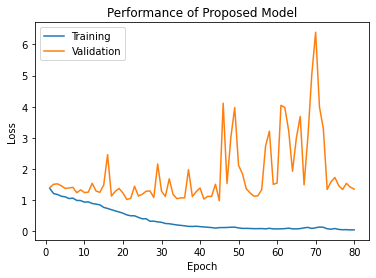

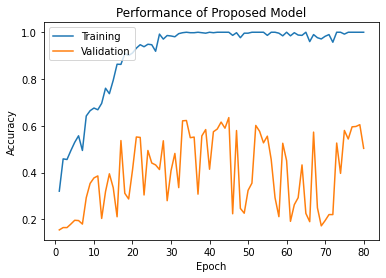

In [ ]:
# Specifying the number of epochs
def accuracy(predictions, labels):
    classes = torch.argmax(predictions, dim=1)
    return torch.mean((classes == labels).float())

def trainNet(model,criterion,optimizer,n_epochs,flag_cuda):
  # Unpacking the number of epochs to train the model
  epochs_list = [*range(1,n_epochs+1)]

  # List to store loss to visualize
  train_losslist = []
  valid_losslist = []
  valid_loss_min = np.Inf # track change in validation loss
  train_running_accuracy = []
  val_running_Accuracy = []
  l2_weight = 0.0001

  for epoch in epochs_list:
      # Keeping track of training and validation loss
      train_loss = 0.0
      valid_loss = 0.0
      train_acc = 0.0
      val_acc = 0.0
      l2_penalty = 0.0
      
      ######################
      # Training the model #
      ######################
      model.train()
      for data, target in train_loader:
          # Moving tensors to GPU if CUDA is available
          if flag_cuda:
              data, target = data.cuda(), target.cuda()
          # Clearing the gradients of all optimized variables
          optimizer.zero_grad()
          # Forward pass: Computing predicted outputs
          output = model(data)
          # Calculating the batch loss
          loss = criterion(output, target)
          # Backward pass: compute gradient of loss with respect to parameters
          loss.backward()

          # compute penalty only for net.hidden parameters
          # l1_penalty = l1_weight * sum([p.abs().sum() for p in net.hidden.parameters()])
          l2_penalty = l2_weight * sum([(p**2).sum() for p in model.parameters()])
          loss = loss + l2_penalty

          # Perform a single optimization step (parameter update)
          optimizer.step()
          # Update training loss
          train_loss += loss.item()*data.size(0)
          train_acc += accuracy(output, target) # added

          
      ########################    
      # Validating the model #
      ########################
      model.eval()
      for data, target in validation_loader:
          # Moving tensors to GPU if CUDA is available
          if flag_cuda:
              data, target = data.cuda(), target.cuda()
          output = model(data)
          loss = criterion(output, target)
          valid_loss += loss.item()*data.size(0)
          val_acc += accuracy(output, target)
      
      # Calculating average losses
      train_loss = train_loss/train_indx
      valid_loss = valid_loss/valid_indx
      train_acc /= len(train_loader)
      train_running_accuracy.append(train_acc)
      val_acc /= len(validation_loader)
      val_running_Accuracy.append(val_acc)
      train_losslist.append(train_loss)
      valid_losslist.append(valid_loss)
          
      # Printing training/validation statistics 
      print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
          epoch, train_loss, valid_loss))
      
      # Saving model if validation loss has decreased
      if valid_loss <= valid_loss_min:
          print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
              valid_loss_min,valid_loss))
          torch.save(model.state_dict(), 'model_cifar.pt')
          valid_loss_min = valid_loss
        
  return epochs_list, train_losslist, valid_losslist, train_running_accuracy, val_running_Accuracy

# Executing the training
epochs_list, train_losslist, valid_losslist, train_acclist, valid_acclist = trainNet(
    model,criterion,optimizer,n_epochs,flag_cuda)

# Loading the best model
model.load_state_dict(torch.load('model_cifar.pt'))

# Plotting the learning curves
plt.plot(epochs_list, train_losslist, epochs_list, valid_losslist)
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend(['Training','Validation'])
plt.title("Performance of Proposed Model")
plt.show()


# Plotting the learning curves
plt.plot(epochs_list, train_acclist, epochs_list, valid_acclist)
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend(['Training','Validation'])
plt.title("Performance of Proposed Model")
plt.show()

In [ ]:
# f1 score
def f1_score_by_class(outputs, labels):
  return f1_score(outputs,labels, average=None)

def assessNet(model,criterion):
  # Tracking test loss and accuracy
  test_loss = 0.0
  class_correct = list(0. for i in range(len(classes)))
  class_total = list(0. for i in range(len(classes)))
  actual_class = []
  predicted_class = []
  predicted_label = []
  actual_label = []

  # Setting model to evaluate
  model.eval()

  # Iterating over batches of test data
  for data, target in validation_loader:
      # Obtaining predictions and loss
      if flag_cuda:
          data, target = data.cuda(), target.cuda()
      output = model(data)
      loss = criterion(output, target)
      test_loss += loss.item()*data.size(0)

      # Converting output probabilities to predicted class
      _, pred = torch.max(output, 1) 
      correct_tensor = pred.eq(target.data.view_as(pred))
      correct = np.squeeze(correct_tensor.numpy()) if not flag_cuda else np.squeeze(correct_tensor.cpu().numpy())
      y_hat = np.squeeze(pred.numpy()) if not flag_cuda else np.squeeze(pred.cpu().numpy())
      y = np.squeeze(target.data.numpy()) if not flag_cuda else np.squeeze(target.data.cpu().numpy())
      predicted_label.extend(y_hat)
      actual_label.extend(y)

      # Calculating test accuracy for each object class
      for i in range(len(data)):
          label = target.data[i]
          class_correct[label] += correct[i].item()
          class_total[label] += 1

  # Computing the average test loss
  test_loss = test_loss/len(validation_loader.dataset)
  print('Test Loss: {:.6f}\n'.format(test_loss))

  # Computing the class accuracies
  for i in range(4):
      if class_total[i] > 0:
          print('Test Accuracy of %10s: %2d%% (%2d/%2d)' % (
              classes[i], 100 * class_correct[i] / class_total[i],
              np.sum(class_correct[i]), np.sum(class_total[i])))
      else:
          print('Test Accuracy of %10s: N/A (no training examples)' % (classes[i]))

  # Computing the overall accuracy
  print('\nTest Accuracy (Overall): %2d%% (%2d/%2d)' % (
      100. * np.sum(class_correct) / np.sum(class_total),
      np.sum(class_correct), np.sum(class_total)))
  

  # F1 score by class
  print('\nF1 Score: {}'.format(f1_score_by_class(actual_label, predicted_label)))

# Executing the assessment
assessNet(model,criterion)

Test Loss: 0.983598

Test Accuracy of   cataract: 83% (25/30)
Test Accuracy of   glaucoma: 41% (13/31)
Test Accuracy of     normal: 81% (73/90)
Test Accuracy of retina_disease: 16% ( 5/30)

Test Accuracy (Overall): 64% (116/181)

F1 Score: [0.74626866 0.48148148 0.73366834 0.23809524]


In [ ]:
def assessNet(model,criterion):
  # Tracking test loss and accuracy
  test_loss = 0.0
  class_correct = list(0. for i in range(len(classes)))
  class_total = list(0. for i in range(len(classes)))
  actual_class = []
  predicted_class = []

  # Setting model to evaluate
  model.eval()

  # Iterating over batches of test data
  for data, target in train_loader:
      # Obtaining predictions and loss
      if flag_cuda:
          data, target = data.cuda(), target.cuda()
      output = model(data)
      loss = criterion(output, target)
      test_loss += loss.item()*data.size(0)

      # Converting output probabilities to predicted class
      _, pred = torch.max(output, 1) 
      correct_tensor = pred.eq(target.data.view_as(pred))
      correct = np.squeeze(correct_tensor.numpy()) if not flag_cuda else np.squeeze(correct_tensor.cpu().numpy())

      # Calculating test accuracy for each object class
      for i in range(len(data)):
          label = target.data[i]
          class_correct[label] += correct[i].item()
          class_total[label] += 1

  # Computing the average test loss
  test_loss = test_loss/len(train_loader.dataset)
  print('Train Loss: {:.6f}\n'.format(test_loss))

  # Computing the class accuracies
  for i in range(4):
      if class_total[i] > 0:
          print('Train Accuracy of %10s: %2d%% (%2d/%2d)' % (
              classes[i], 100 * class_correct[i] / class_total[i],
              np.sum(class_correct[i]), np.sum(class_total[i])))
      else:
          print('Train Accuracy of %10s: N/A (no training examples)' % (classes[i]))

  # Computing the overall accuracy
  print('\nTrain Accuracy (Overall): %2d%% (%2d/%2d)' % (
      100. * np.sum(class_correct) / np.sum(class_total),
      np.sum(class_correct), np.sum(class_total)))
  
# Executing the assessment
assessNet(model,criterion)

Train Loss: 0.133846

Train Accuracy of   cataract: 100% (104/104)
Train Accuracy of   glaucoma: 100% (104/104)
Train Accuracy of     normal: 100% (109/109)
Train Accuracy of retina_disease: 100% (98/98)

Train Accuracy (Overall): 100% (415/415)
